In [ ]:
import torch
import gc

# Clear Python garbage
gc.collect()

# Clear PyTorch cache
torch.cuda.empty_cache()

# Optionally reset CUDA memory stats
torch.cuda.reset_peak_memory_stats()


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import matplotlib.pyplot as plt

# --- 1. Set paths for your data ---
csv_path = "/home/hipe2/Pictures/30k_dataset/flickr30k_images/results.csv"
image_dir = "/home/hipe2/Pictures/30k_dataset/flickr30k_images/images_"

# --- 2. Load the CSV and select a sample ---
df = pd.read_csv(csv_path, sep='|')
df.columns = [col.strip() for col in df.columns]
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_dir, x))
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Pick one sample (change the index to try a different image)
idx = 15
sample = df.iloc[idx]
image_path = sample['image_path']
caption = sample['comment']

# --- 3. Load the image ---
image = Image.open(image_path).convert("RGB")

# --- 4. Load model and processor ---
model_id = "visheratin/MC-LLaVA-3b"
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    trust_remote_code=True
).to("cuda" if torch.cuda.is_available() else "cpu")

# --- 5. Build the prompt in ChatML format (as required by MC-LLaVA-3b) ---
prompt = (
    "<|im_start|>user\n"
    f"<image>\nDescribe this image in a short and simple sentence, no more than 10 words.\nCaption: {caption}\nNarrative:\n"
    "<|im_end|>\n"
    "<|im_start|>assistant\n"
)

# --- 6. Prepare inputs with the processor (pass model for vision features) ---
inputs = processor(prompt, [image], model, return_tensors="pt")
inputs = {k: v.to(model.device) if torch.is_tensor(v) else v for k, v in inputs.items()}

# --- 7. Generate the narrative ---
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=64,
        use_cache=True,
        do_sample=False,
        eos_token_id=processor.tokenizer.eos_token_id,
        pad_token_id=processor.tokenizer.eos_token_id
    )

# --- 8. Decode and clean up the output ---
generated_text = processor.tokenizer.decode(output[0], skip_special_tokens=True)
# Remove the prompt and special tokens to isolate the narrative
narrative = generated_text.replace(prompt, "").replace("<|im_end|>", "").strip()

# --- 9. Display the image, original caption, and generated narrative ---
plt.imshow(image)
plt.axis('off')
plt.title("Sample Image")
plt.show()

print("Original Caption:\n", caption)
print("\nLLaVA Narrative:\n", narrative)


No module named 'flash_attn'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

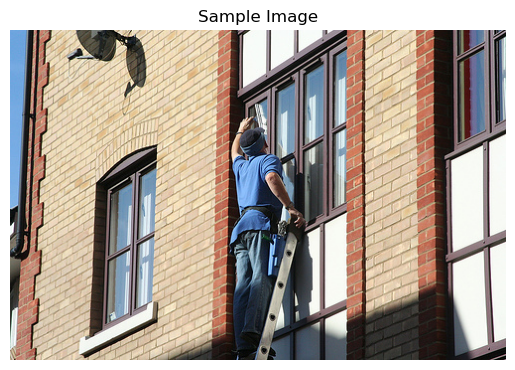

Original Caption:
  Someone in a blue shirt and hat is standing on stair and leaning against a window .

LLaVA Narrative:
 A man in a blue shirt and hat is cleaning a window on a brick building.


IntSlider(value=0, continuous_update=False, description='Fade Level:', max=16)

Output()

In [2]:
# --- 1. Import required libraries ---
import os
import pandas as pd
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
import matplotlib.pyplot as plt

# For interactive output and image display in Jupyter
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import Image as IPyImage  # For alternative image display

import re  # For narrative extraction

# --- 2. Set paths for your data ---
csv_path = "/home/hipe2/Pictures/30k_dataset/flickr30k_images/results.csv"
image_dir = "/home/hipe2/Pictures/30k_dataset/flickr30k_images/images_"

# --- 3. Load the CSV and select a sample ---
df = pd.read_csv(csv_path, sep='|')
df.columns = [col.strip() for col in df.columns]
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_dir, x))
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Pick one sample (change idx for a different image)
idx = 15
sample = df.iloc[idx]
image_path = sample['image_path']
caption = sample['comment']

# --- 4. Load the image ---
image = Image.open(image_path).convert("RGB")

# --- 5. Load model and processor ---
model_id = "visheratin/MC-LLaVA-3b"
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    trust_remote_code=True
).to("cuda" if torch.cuda.is_available() else "cpu")

# --- 6. Build the prompt in ChatML format (as required by MC-LLaVA-3b) ---
prompt = (
    "<|im_start|>user\n"
    f"<image>\nDescribe this image in a short and simple sentence, no more than 10 words.\nCaption: {caption}\nNarrative:\n"
    "<|im_end|>\n"
    "<|im_start|>assistant\n"
)

# --- 7. Prepare inputs with the processor (pass model for vision features) ---
inputs = processor(prompt, [image], model, return_tensors="pt")
inputs = {k: v.to(model.device) if torch.is_tensor(v) else v for k, v in inputs.items()}

# --- 8. Generate the narrative ---
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=64,
        use_cache=True,
        do_sample=False,
        eos_token_id=processor.tokenizer.eos_token_id,
        pad_token_id=processor.tokenizer.eos_token_id
    )

# --- 9. Extract only the generated narrative (not the prompt or special tokens) ---
generated_text = processor.tokenizer.decode(output[0], skip_special_tokens=True)

# Use regex to extract only the text after the last assistant start token
narrative_parts = re.split(r"<\|im_start\|>assistant", generated_text)
if len(narrative_parts) > 1:
    narrative = narrative_parts[-1]
else:
    narrative = generated_text
narrative = narrative.replace("<|im_end|>", "").strip()

# --- 10. Display the image ---
# Option 1: With matplotlib (recommended, works with PIL images)
plt.imshow(image)
plt.axis('off')
plt.title("Sample Image")
plt.show()

# Option 2: With IPython.display.Image (works with local file paths)
# display(IPyImage(filename=image_path, width=400))

# --- 11. Print the original caption and the generated narrative ---
print("Original Caption:\n", caption)
print("\nLLaVA Narrative:\n", narrative)

# --- 12. Fading function ---
def get_faded_prompt(words, fade_level):
    """
    Returns the narrative with the last `fade_level` words replaced by blanks.
    Args:
        words (list of str): The narrative split into words.
        fade_level (int): Number of words to fade from the end.
    Returns:
        str: The faded narrative.
    """
    if fade_level == 0:
        return " ".join(words)
    faded_words = [
        word if i < len(words) - fade_level else "___"
        for i, word in enumerate(words)
    ]
    return " ".join(faded_words)

# --- 13. Interactive fading with ipywidgets ---
words = narrative.split()

fade_slider = widgets.IntSlider(
    value=0,                      # Start with no fading
    min=0,                        # Minimum fade (no words faded)
    max=len(words),               # Maximum fade (all words faded)
    step=1,                       # Fade one word at a time
    description='Fade Level:',
    continuous_update=False       # Only update on slider release
)

output = widgets.Output()

def update_faded_prompt(change):
    """
    Updates the output area with the faded prompt based on the slider value.
    """
    with output:
        clear_output(wait=True)
        print("Faded Prompt:\n", get_faded_prompt(words, fade_slider.value))

fade_slider.observe(update_faded_prompt, names='value')
display(fade_slider, output)
update_faded_prompt(None)
